# Task 1: Inner Workings of ResNet-152

### 1. Baseline Setup

In [ ]:
!pip install torch torchvision torchaudio transformers umap-learn scikit-learn matplotlib seaborn huggingface_hub

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
model = torchvision.models.resnet152(weights='IMAGENET1K_V1').to(device)
print('Pre-trained ResNet-152 loaded successfully.')
print(model)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 195MB/s]


Pre-trained ResNet-152 loaded successfully.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Con

In [ ]:
num_features = model.fc.in_features
print(num_features)
model.fc = nn.Linear(num_features, 10).to(device)
print(model.fc)

2048
Linear(in_features=2048, out_features=10, bias=True)


In [ ]:
for param in model.parameters():
    param.requires_grad = False  # Freeze everything
for param in model.fc.parameters():
    param.requires_grad = True  # Unfreeze only the FC

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable parameters: {trainable_params} (only the head)')

Trainable parameters: 20490 (only the head)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


In [ ]:
epochs = 3
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

Epoch 1/3: Train Loss: 0.6693, Val Loss: 0.5025, Val Acc: 82.82%
Epoch 2/3: Train Loss: 0.5130, Val Loss: 0.4878, Val Acc: 83.09%
Epoch 3/3: Train Loss: 0.4927, Val Loss: 0.4869, Val Acc: 83.50%


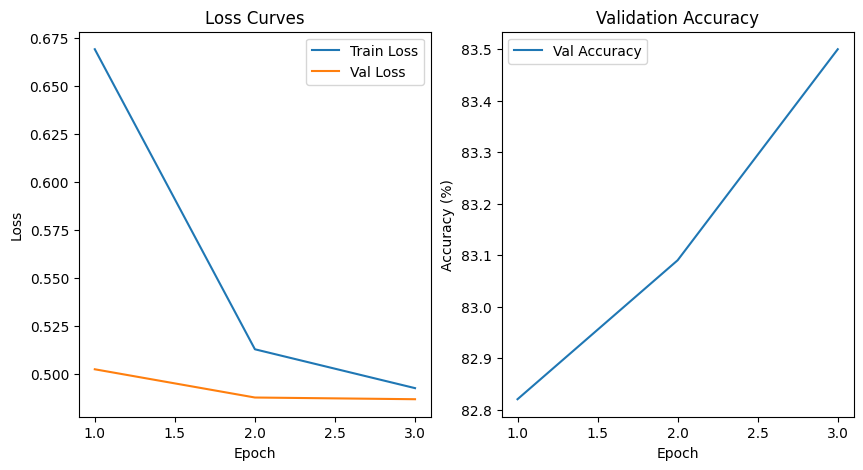

In [ ]:
# Plot performance
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

### 2. Residual Connections in Practice

In [ ]:
# (a) Disable skip connections in selected blocks
class ModifiedResNet(nn.Module):
    def __init__(self, original_model, disable_blocks):
        super().__init__()
        self.model = original_model
        self.disable_blocks = disable_blocks
        self.original_forwards = {}
        for block_name in disable_blocks:
            block = self.model
            for part in block_name.split('.'):
                block = getattr(block, part)
            self.original_forwards[block_name] = block.forward
            # Replace forward to skip addition
            def no_skip_forward(self_block, x):
                out = self_block.conv1(x)
                out = self_block.bn1(out)
                out = self_block.relu(out)
                out = self_block.conv2(out)
                out = self_block.bn2(out)
                if hasattr(self_block, 'conv3'):
                    out = self_block.conv3(out)
                    out = self_block.bn3(out)
                return self_block.relu(out)
            import types
            block.forward = types.MethodType(no_skip_forward, block)

    def forward(self, x):
        return self.model(x)

# Select blocks to disable (e.g., first two blocks of layer4)
disable_blocks = ['layer4.0', 'layer4.1']
modified_model = ModifiedResNet(model, disable_blocks).to(device)

# Replace FC layer for CIFAR-10 (fresh head)
modified_model.model.fc = nn.Linear(modified_model.model.fc.in_features, 10).to(device)

# Freeze backbone, unfreeze FC
for param in modified_model.parameters():
    param.requires_grad = False
for param in modified_model.model.fc.parameters():
    param.requires_grad = True

# Verify trainable params
trainable_params = sum(p.numel() for p in modified_model.parameters() if p.requires_grad)
print(f'Trainable parameters: {trainable_params} (only the head)')

Trainable parameters: 20490 (only the head)


In [ ]:
optimizer = torch.optim.Adam(modified_model.model.fc.parameters(), lr=0.001)

epochs = 3
train_losses_mod = []
val_losses_mod = []
val_accuracies_mod = []

for epoch in range(epochs):
    modified_model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses_mod.append(train_loss / len(train_loader))

    # Validation
    modified_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = modified_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses_mod.append(val_loss / len(test_loader))
    val_accuracies_mod.append(100 * correct / total)

    print(f'Modified Model - Epoch {epoch+1}/{epochs}: Train Loss: {train_losses_mod[-1]:.4f}, Val Loss: {val_losses_mod[-1]:.4f}, Val Acc: {val_accuracies_mod[-1]:.2f}%')

Modified Model - Epoch 1/3: Train Loss: 0.8708, Val Loss: 0.7073, Val Acc: 76.41%
Modified Model - Epoch 2/3: Train Loss: 0.6922, Val Loss: 0.6541, Val Acc: 78.09%
Modified Model - Epoch 3/3: Train Loss: 0.6630, Val Loss: 0.6583, Val Acc: 78.16%


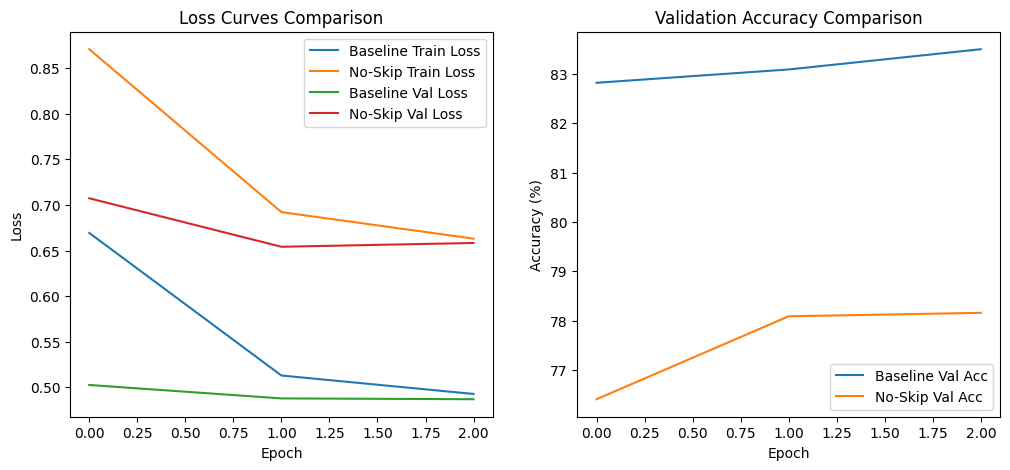

In [ ]:
# Compare with baseline
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Baseline Train Loss')  # From Task 1
plt.plot(train_losses_mod, label='No-Skip Train Loss')
plt.plot(val_losses, label='Baseline Val Loss')
plt.plot(val_losses_mod, label='No-Skip Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves Comparison')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Baseline Val Acc')  # From Task 1
plt.plot(val_accuracies_mod, label='No-Skip Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.show()

### 3: Feature Hierarchies and Representations

In [ ]:
import torch
import numpy as np

features = {}
def get_features(name):
    def hook(module, input, output):
        features[name] = output.detach()
    return hook
model.layer1.register_forward_hook(get_features('layer1'))
model.layer3.register_forward_hook(get_features('layer3'))
model.layer4.register_forward_hook(get_features('layer4'))

model.eval()
all_features = {'layer1': [], 'layer3': [], 'layer4': []}
all_labels = []

with torch.no_grad():
    sample_count = 0
    for images, labels in test_loader:
        images = images.to(device)
        _ = model(images)
        for layer in ['layer1', 'layer3', 'layer4']:
            layer_feats = features[layer].cpu().view(features[layer].size(0), -1)
            all_features[layer].append(layer_feats)
        all_labels.append(labels.cpu())
        sample_count += images.size(0)
        if sample_count >= 1000:
            break
for layer in all_features:
    all_features[layer] = torch.cat(all_features[layer])[:1000]  # Limit to 1000
all_labels = torch.cat(all_labels)[:1000]

print('Features collected:')
for layer in all_features:
    print(f'{layer}: shape {all_features[layer].shape}')

Features collected:
layer1: shape torch.Size([1000, 802816])
layer3: shape torch.Size([1000, 200704])
layer4: shape torch.Size([1000, 100352])


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


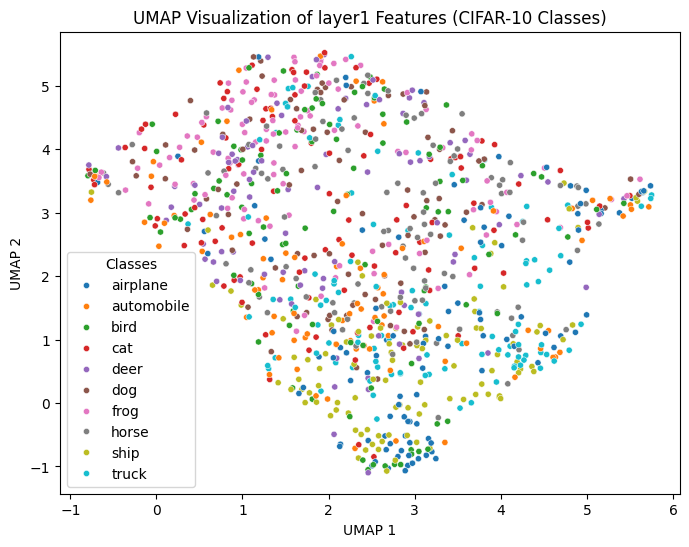

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


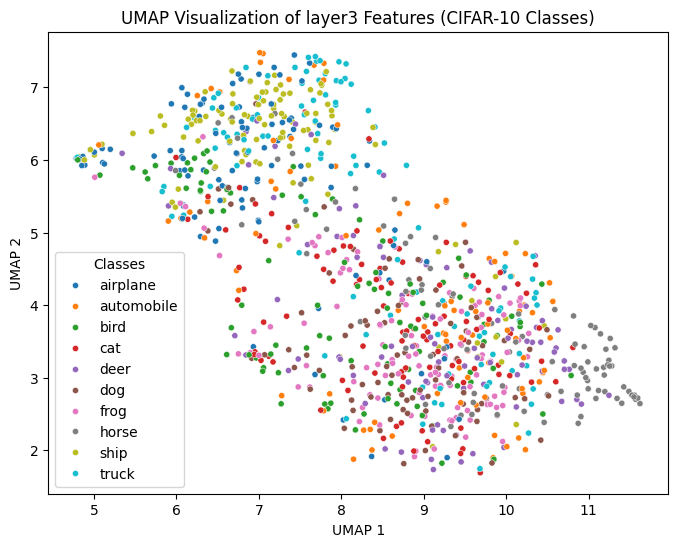

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


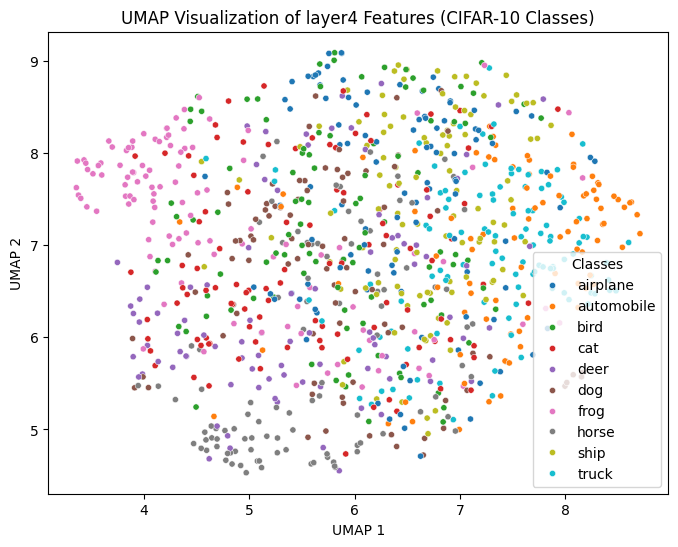

In [ ]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # Optional for t-SNE

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for layer in ['layer1', 'layer3', 'layer4']:
    reducer = umap.UMAP(n_components=2, random_state=42)
    embeds = reducer.fit_transform(all_features[layer].numpy())

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embeds[:, 0], y=embeds[:, 1], hue=all_labels.numpy(), palette='tab10', s=20, legend='full')
    plt.title(f'UMAP Visualization of {layer} Features (CIFAR-10 Classes)')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, [class_names[int(l)] for l in labels], title='Classes')
    plt.show()

### 4. Transfer Learning and Generalization

In [ ]:
# (a) Load CIFAR-100 dataset (different from ImageNet/CIFAR-10)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset_100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
train_loader_100 = DataLoader(train_dataset_100, batch_size=64, shuffle=True)
test_loader_100 = DataLoader(test_dataset_100, batch_size=64, shuffle=False)

model_pretrained = torchvision.models.resnet152(weights='IMAGENET1K_V1').to(device)
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, 100).to(device)

for param in model_pretrained.parameters():
    param.requires_grad = False
for param in model_pretrained.fc.parameters():
    param.requires_grad = True

100%|██████████| 169M/169M [01:46<00:00, 1.59MB/s]


In [ ]:
optimizer_pre = torch.optim.Adam(model_pretrained.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, optimizer, epochs=3, loader_train=train_loader_100, loader_test=test_loader_100):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in loader_train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(loader_train))

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader_test:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(loader_test))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

    return train_losses, val_losses, val_accuracies

print('Fine-tuning pretrained model on CIFAR-100 (head-only)...')
train_losses_pre, val_losses_pre, val_accuracies_pre = train_model(model_pretrained, optimizer_pre, epochs=3)

Fine-tuning pretrained model on CIFAR-100 (head-only)...
Epoch 1/3: Train Loss: 1.9352, Val Loss: 1.4061, Val Acc: 60.51%
Epoch 2/3: Train Loss: 1.3548, Val Loss: 1.3988, Val Acc: 60.71%
Epoch 3/3: Train Loss: 1.2503, Val Loss: 1.3358, Val Acc: 62.29%


In [ ]:
model_random = torchvision.models.resnet152(weights=None).to(device)  # No pretrained weights
model_random.fc = nn.Linear(model_random.fc.in_features, 100).to(device)

for param in model_random.parameters():
    param.requires_grad = False
for param in model_random.fc.parameters():
    param.requires_grad = True

In [ ]:
# Optimizer
optimizer_rand = torch.optim.Adam(model_random.fc.parameters(), lr=0.001)

print('Training random init model on CIFAR-100 (head-only)...')
train_losses_rand, val_losses_rand, val_accuracies_rand = train_model(model_random, optimizer_rand, epochs=3)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_pre, label='Pretrained Train Loss')
plt.plot(train_losses_rand, label='Random Train Loss')
plt.plot(val_losses_pre, label='Pretrained Val Loss')
plt.plot(val_losses_rand, label='Random Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves Comparison')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_pre, label='Pretrained Val Acc')
plt.plot(val_accuracies_rand, label='Random Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.show()

Training random init model on CIFAR-100 (head-only)...


In [ ]:
model_block = torchvision.models.resnet152(weights='IMAGENET1K_V1').to(device)
model_block.fc = nn.Linear(model_block.fc.in_features, 100).to(device)

# Freeze all except layer4 and FC
for param in model_block.parameters():
    param.requires_grad = False
for param in model_block.layer4.parameters():
    param.requires_grad = True
for param in model_block.fc.parameters():
    param.requires_grad = True

trainable_params_block = sum(p.numel() for p in model_block.parameters() if p.requires_grad)
print(f'Final block trainable params: {trainable_params_block}')

optimizer_block = torch.optim.Adam(filter(lambda p: p.requires_grad, model_block.parameters()), lr=0.0001)  # Lower lr to avoid overfitting

print('Fine-tuning final block on CIFAR-100...')
train_losses_block, val_losses_block, val_accuracies_block = train_model(model_block, optimizer_block, epochs=3)

Final block trainable params: 15169636
Fine-tuning final block on CIFAR-100...
Epoch 1/3: Train Loss: 1.5553, Val Loss: 0.9850, Val Acc: 71.43%
Epoch 2/3: Train Loss: 0.7115, Val Loss: 0.8761, Val Acc: 74.04%
Epoch 3/3: Train Loss: 0.4004, Val Loss: 0.9202, Val Acc: 73.90%


In [ ]:
# Full backbone fine-tuning (unfreeze all)
model_full = torchvision.models.resnet152(weights='IMAGENET1K_V1').to(device)
model_full.fc = nn.Linear(model_full.fc.in_features, 100).to(device)

# Unfreeze all
for param in model_full.parameters():
    param.requires_grad = True

trainable_params_full = sum(p.numel() for p in model_full.parameters() if p.requires_grad)
print(f'Full backbone trainable params: {trainable_params_full}')

optimizer_full = torch.optim.Adam(model_full.parameters(), lr=0.00001)

print('Fine-tuning full backbone on CIFAR-100...')
train_losses_full, val_losses_full, val_accuracies_full = train_model(model_full, optimizer_full, epochs=3)

Full backbone trainable params: 58348708
Fine-tuning full backbone on CIFAR-100...
Epoch 1/3: Train Loss: 2.7996, Val Loss: 1.2746, Val Acc: 71.65%
Epoch 2/3: Train Loss: 0.9534, Val Loss: 0.7377, Val Acc: 80.25%
Epoch 3/3: Train Loss: 0.4990, Val Loss: 0.6175, Val Acc: 82.29%


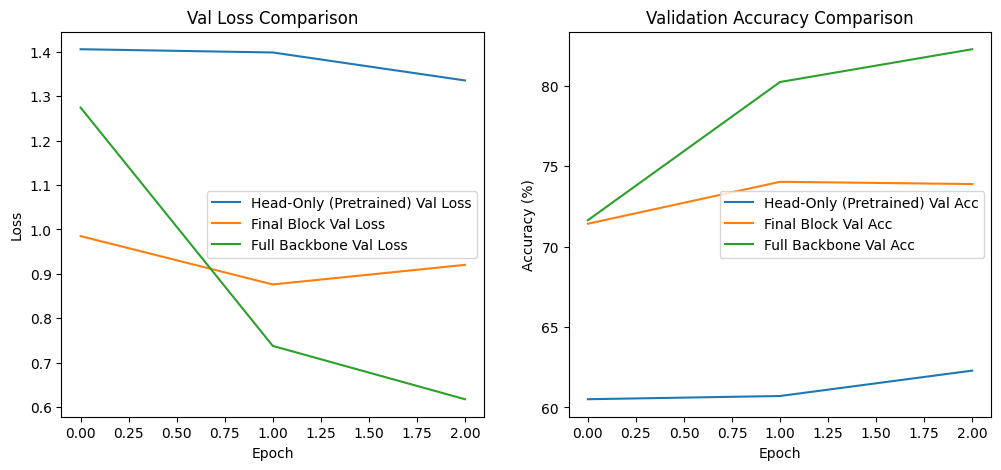

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(val_losses_pre, label='Head-Only (Pretrained) Val Loss')
plt.plot(val_losses_block, label='Final Block Val Loss')
plt.plot(val_losses_full, label='Full Backbone Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Val Loss Comparison')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_pre, label='Head-Only (Pretrained) Val Acc')
plt.plot(val_accuracies_block, label='Final Block Val Acc')
plt.plot(val_accuracies_full, label='Full Backbone Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.show()